## Velocity Fields with GLAD Data & Clouddrift (for intermediate users)

This notebook demonstrates how to utilize [CloudDrift](https://github.com/Cloud-Drift/clouddrift) to easily manipulate and visualize velocity fields from the [GLAD](https://data.griidc.org/data/R1.x134.073:0004) dataset. This notebook is inspired by the paper [Statistical properties of the surface velocity field in the northern Gulf of Mexico sampled by GLAD drifters](https://doi.org/10.1002/2015JC011569).

In [1]:
# library imports
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import RBFInterpolator

# clouddrift import
import clouddrift as cd
from clouddrift.ragged import apply_ragged, chunk

As with the glad-get-started notebook, we will use the `datasets.glad()` function to load the GLAD dataset.

In [22]:
# load the GLAD dataset
ds = cd.datasets.glad()

Let's start by looking at a simple spaghetti plot of the velocity fields. Here we're showing the tragectory of each drifter over time. The colors here are just to distinguish between different drifters.

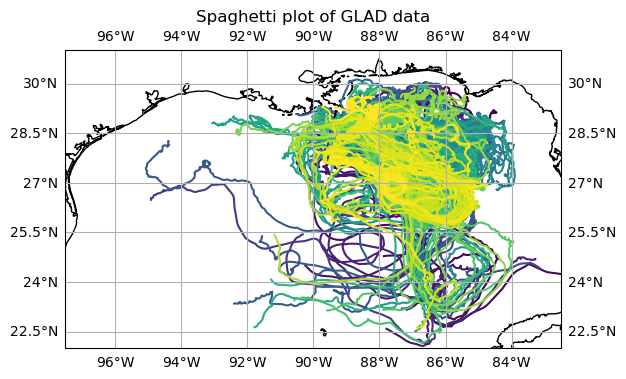

In [23]:
# make figure
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
hl = cd.plotting.plot_ragged(
    ax,
    ds.longitude,
    ds.latitude,
    ds.rowsize,
    transform=ccrs.PlateCarree(),
)
ax.set_extent([-97.5, -82.5, 22, 31], crs=ccrs.PlateCarree())
ax.set_title(f"Spaghetti plot of GLAD data")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.coastlines()
ax.gridlines(draw_labels=True)

Let's try something a little more interesting. In `clouddrift`, we have the ability to "chunk" arrays. That is, using the `chunk` function in the `ragged` module, we can divide an array into equal sized chunks of some length. We also have the ability to set an overlap between these chunks. The output is a 2D NumPy array of shape `(n_chunks, chunk_length)`.

Another important feature of `clouddrift` is to be able to apply functions to ragged arrays. This is handled by the `ragged.apply_ragged` function, which takes a funciton and its arguments and the rowsizes for the ragged array. In this case, the function is then applied to each chunk of the ragged array.

We want to look at two cases of chunking using the eastward and northward velocities: 1. 10 day intervals with a 6 day overlap, and 2. 31 day intervals with a 25 day overlap.

In [24]:
# load the GLAD dataset
ds = cd.datasets.glad()

# Find the number of 15 minute intervals in 10 and 31 days
# The time interval of the GLAD dataset is 15 minutes
n_intervals_10 = 24 * 10 * 4
n_intervals_31 = 24 * 31 * 4

# Setting an overlap between the chunks
overlap_10 = 24 * 6 * 4
overlap_31 = 24 * 25 * 4

# Get the 10 day and 31 day chunks of the eastward and northward velocities
u_10 = apply_ragged(chunk, ds.u, ds.rowsize, n_intervals_10, overlap_10)
v_10 = apply_ragged(chunk, ds.v, ds.rowsize, n_intervals_10, overlap_10)
lon_10 = apply_ragged(chunk, ds.longitude, ds.rowsize, n_intervals_10, overlap_10)
lat_10 = apply_ragged(chunk, ds.latitude, ds.rowsize, n_intervals_10, overlap_10)

u_31 = apply_ragged(chunk, ds.u, ds.rowsize, n_intervals_31, overlap_31)
v_31 = apply_ragged(chunk, ds.v, ds.rowsize, n_intervals_31, overlap_31)
lon_31 = apply_ragged(chunk, ds.longitude, ds.rowsize, n_intervals_31, overlap_31)
lat_31 = apply_ragged(chunk, ds.latitude, ds.rowsize, n_intervals_31, overlap_31)


To visualize the results, let's find the mean velocity, latitude, and longitude for each chunk and plot the results.

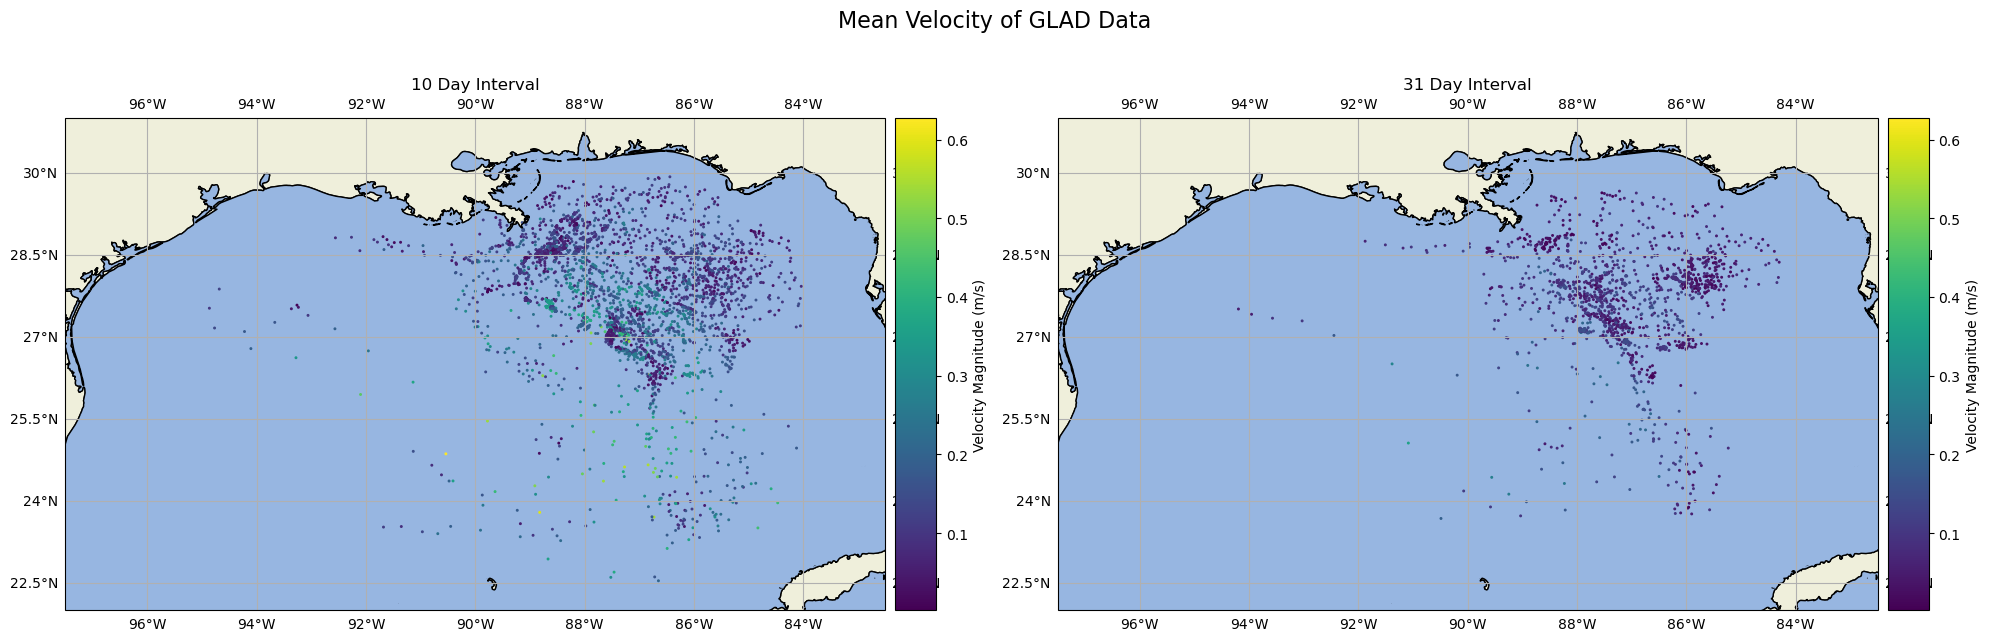

In [25]:
# Calculate the mean eastward and northward velocities for the 10 and 31 day intervals
u_mean_10 = u_10.mean(axis=1)
v_mean_10 = v_10.mean(axis=1)
long_mean_10 = lon_10.mean(axis=1)
lat_mean_10 = lat_10.mean(axis=1)

u_mean_31 = u_31.mean(axis=1)
v_mean_31 = v_31.mean(axis=1)
long_mean_31 = lon_31.mean(axis=1)
lat_mean_31 = lat_31.mean(axis=1)

# Calculate the magnitude of the mean velocities for the 10 and 31 day intervals
magnitude_10 = np.sqrt(u_mean_10**2 + v_mean_10**2)
magnitude_31 = np.sqrt(u_mean_31**2 + v_mean_31**2)

 # Plot the bicubic spline of the 10 and 31 day interval mean data with colored arrows
fig = plt.figure(figsize=(20, 7))
fig.suptitle(f"Mean Velocity of GLAD Data", fontsize=16)

# Set color normalization for consistent scale
vmin = min(magnitude_10.min(), magnitude_31.min())
vmax = max(magnitude_10.max(), magnitude_31.max())
norm = plt.Normalize(vmin=vmin, vmax=vmax)

# Plot the locations of the 10 and 31 day intervals on the map next to one another
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([-97.5, -82.5, 22, 31], crs=ccrs.PlateCarree())
ax1.set_title("10 Day Interval")
ax1.coastlines()
ax1.add_feature(cfeature.LAND, edgecolor='black')
ax1.add_feature(cfeature.OCEAN)
ax1.gridlines(draw_labels=True)

hl1 = ax1.scatter(long_mean_10, lat_mean_10, 
                 c=magnitude_10,
                 norm=norm,
                 cmap='viridis',
                 transform=ccrs.PlateCarree(), 
                 marker=".", 
                 s=5)

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
plt.colorbar(hl1, cax=cax1, label='Velocity Magnitude (m/s)')

ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([-97.5, -82.5, 22, 31], crs=ccrs.PlateCarree())
ax2.set_title("31 Day Interval")
ax2.coastlines()
ax2.add_feature(cfeature.LAND, edgecolor='black')
ax2.add_feature(cfeature.OCEAN)
ax2.gridlines(draw_labels=True)

hl2 = ax2.scatter(long_mean_31, lat_mean_31, 
                 c=magnitude_31,
                 norm=norm,
                 cmap='viridis',
                 transform=ccrs.PlateCarree(), 
                 marker=".", 
                 s=5)

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
plt.colorbar(hl2, cax=cax2, label='Velocity Magnitude (m/s)')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

Lastly, let's use the data chunks and interpolate the velocity fields to a regular grid. We can then plot the interpolated velocity fields and compare how the two different interval lengths compare.

We will use the RBFInterpolator from the `scipy` library to interpolate the velocity fields and compare the results between the two cases and different types of interpolation.

Note: The data is confined to the region above, so be wary of the extrapolated regions exceed that boundary.

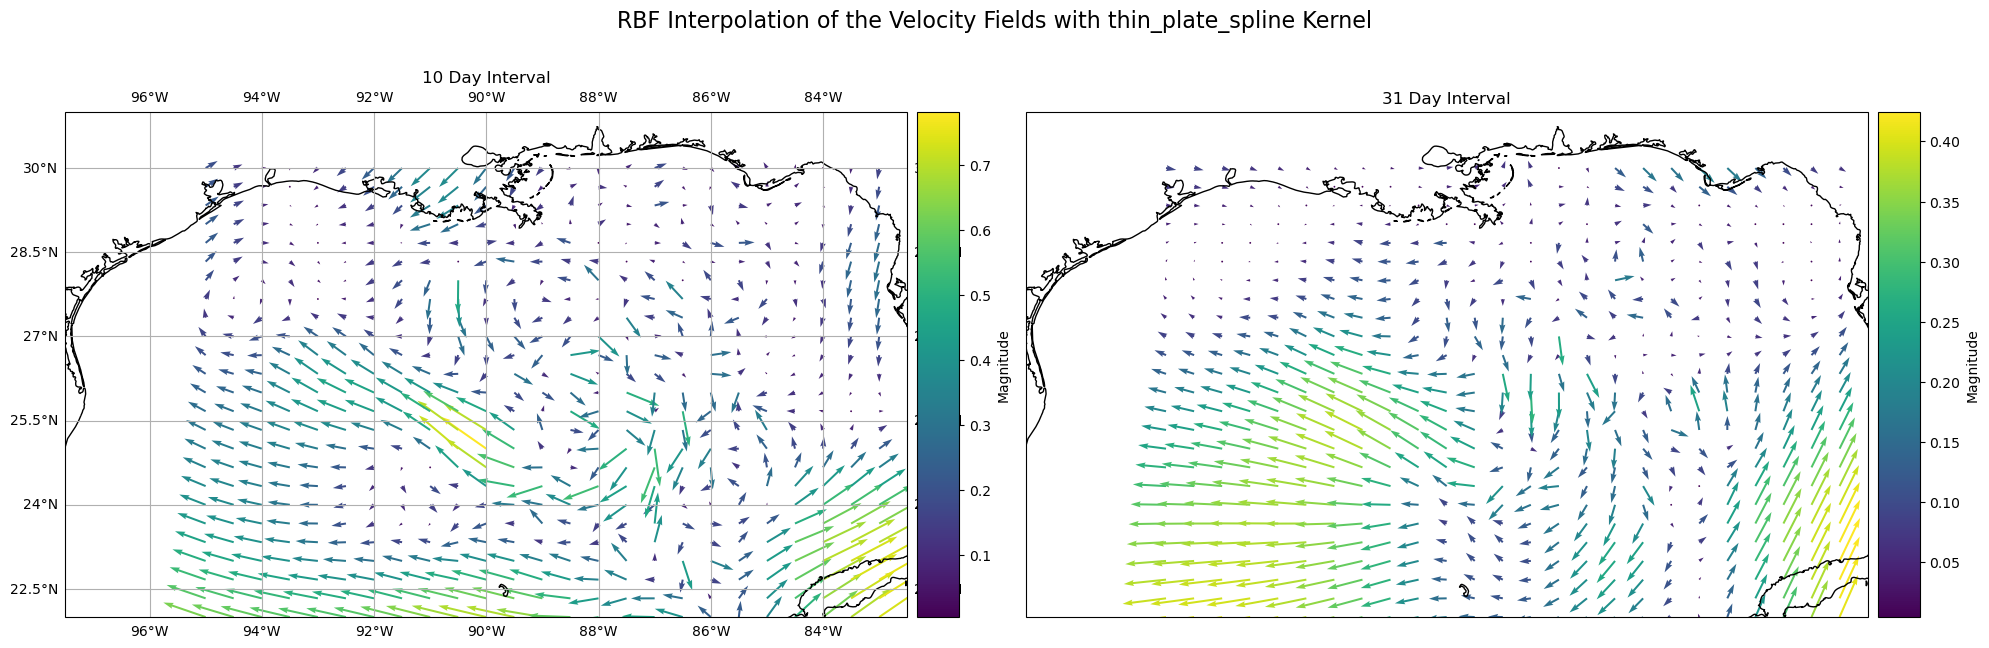

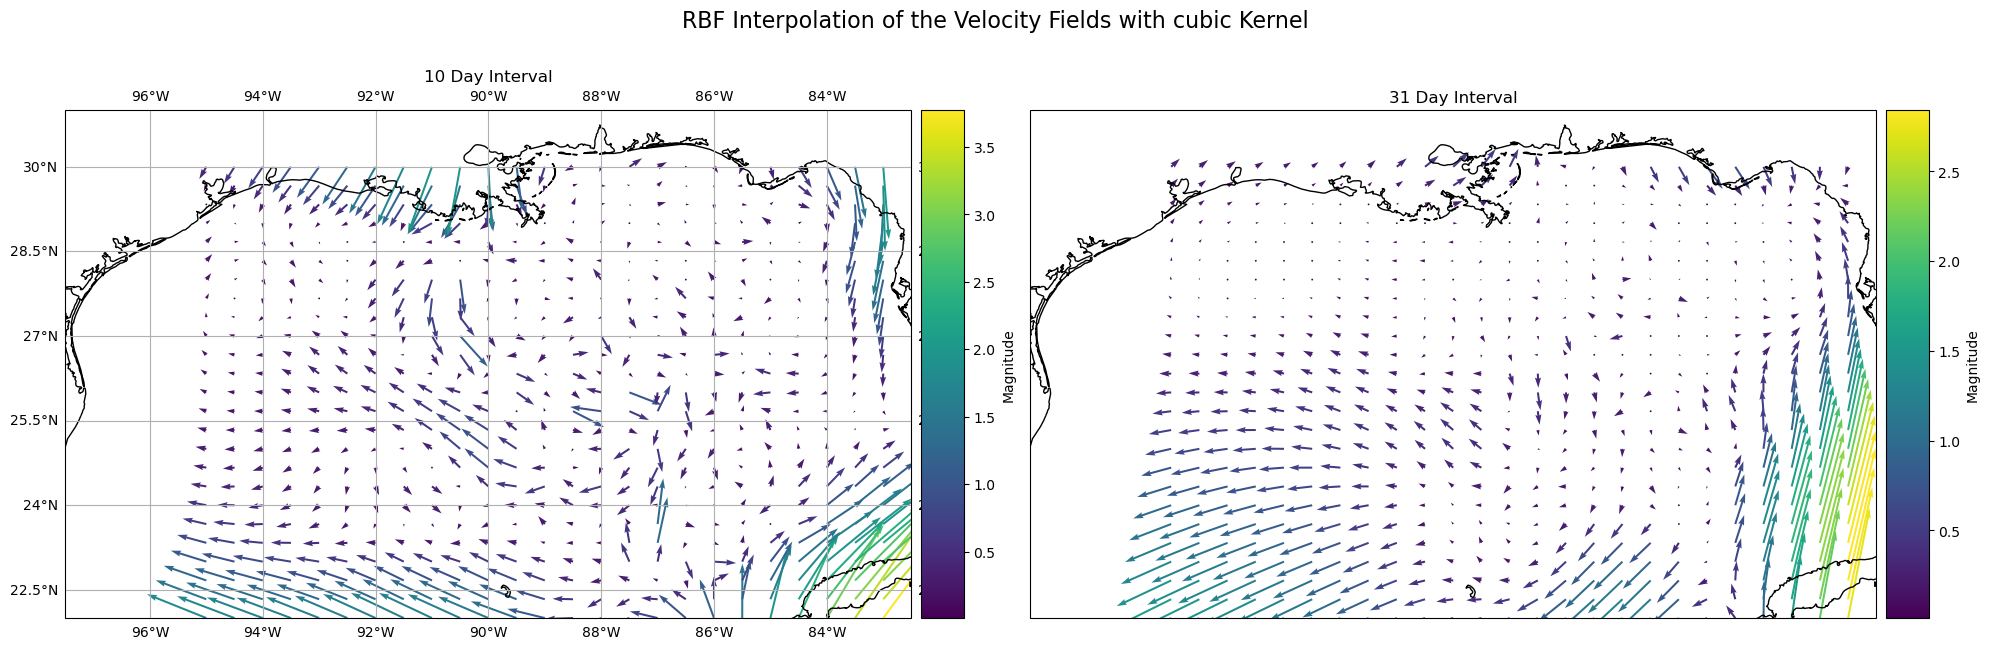

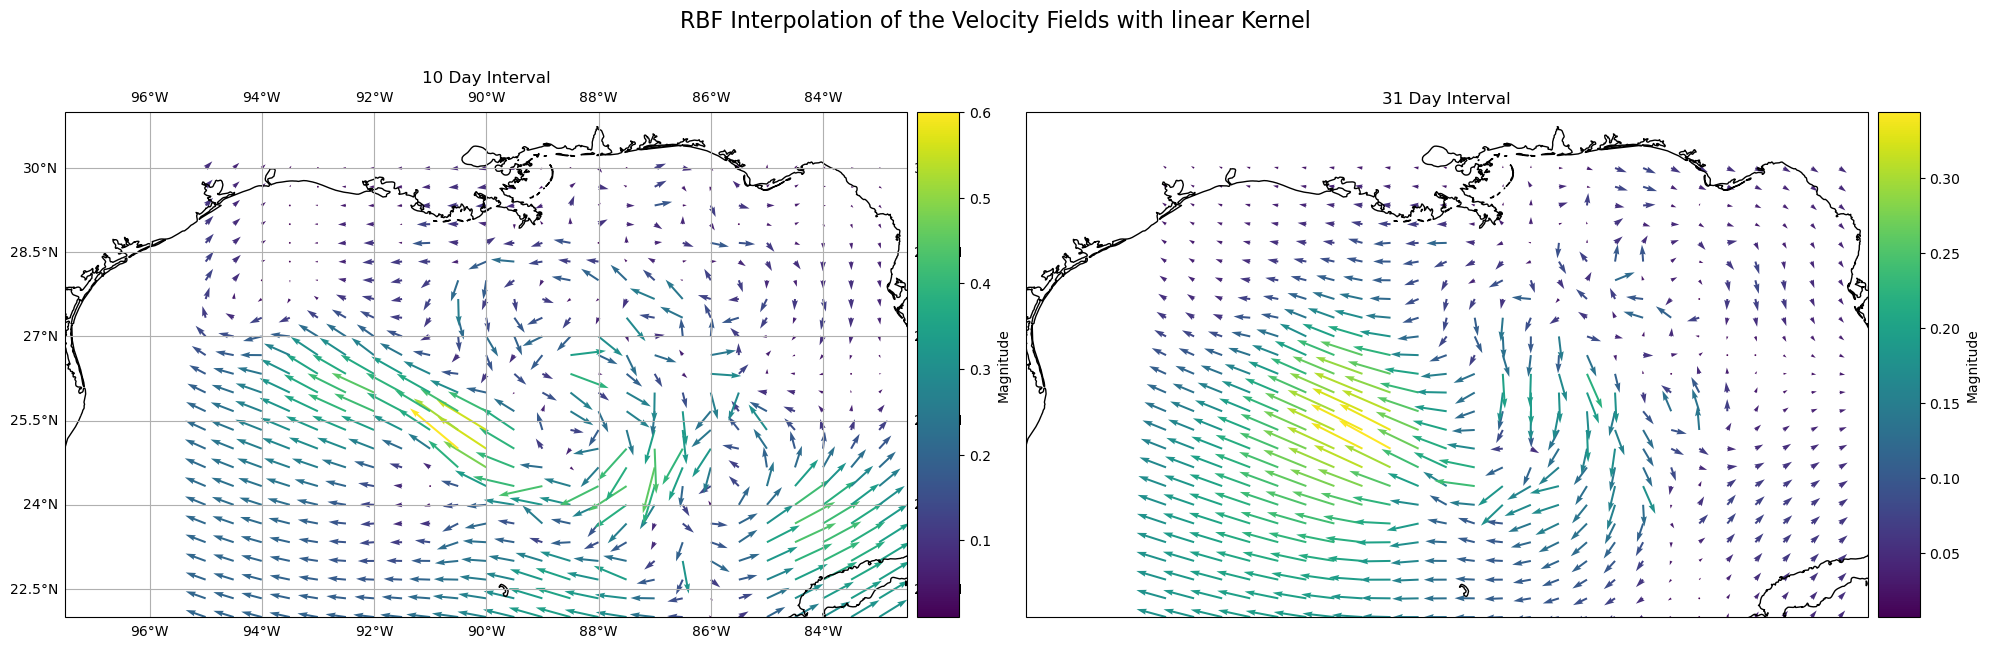

In [30]:
# Stack coordinates for RBF
xy_10 = np.column_stack((long_mean_10, lat_mean_10))
xy_31 = np.column_stack((long_mean_31, lat_mean_31))

kernels = ['thin_plate_spline', 'cubic', 'linear']

for kernel in kernels:
    # Create RBF interpolators with custom parameters
    f_10 = RBFInterpolator(xy_10, u_mean_10, kernel=kernel)
    g_10 = RBFInterpolator(xy_10, v_mean_10, kernel=kernel)

    f_31 = RBFInterpolator(xy_31, u_mean_31, kernel=kernel)
    g_31 = RBFInterpolator(xy_31, v_mean_31, kernel=kernel)

    # Create evaluation grid
    x = np.linspace(-95, -83, 25)
    y = np.linspace(22, 30, 25)
    X, Y = np.meshgrid(x, y)
    xy_grid = np.column_stack((X.ravel(), Y.ravel()))

    # Evaluate interpolation
    u_interp_10 = f_10(xy_grid).reshape(X.shape)
    v_interp_10 = g_10(xy_grid).reshape(X.shape)
    u_interp_31 = f_31(xy_grid).reshape(X.shape)
    v_interp_31 = g_31(xy_grid).reshape(X.shape)

    # Plot the bicubic spline of the 10 and 31 day interval mean data with colored arrows
    fig = plt.figure(figsize=(20, 7))

    # Add title
    fig.suptitle(f"RBF Interpolation of the Velocity Fields with {kernel} Kernel", fontsize=16)

    # Plot for 10 Day Interval
    ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
    ax1.set_extent([-97.5, -82.5, 22, 31], crs=ccrs.PlateCarree())
    ax1.set_title("10 Day Interval")
    ax1.coastlines()
    ax1.gridlines(draw_labels=True)
    magnitude_interp_10 = np.sqrt(u_interp_10**2 + v_interp_10**2)
    hl1 = ax1.quiver(X, Y, u_interp_10, v_interp_10, magnitude_interp_10, 
                    transform=ccrs.PlateCarree(), cmap='viridis')
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
    plt.colorbar(hl1, cax=cax1, label='Magnitude')

    # Plot for 31 Day Interval
    ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
    ax2.set_extent([-97.5, -82.5, 22, 31], crs=ccrs.PlateCarree())
    ax2.set_title("31 Day Interval")
    ax2.coastlines()
    magnitude_interp_31 = np.sqrt(u_interp_31**2 + v_interp_31**2)
    hl2 = ax2.quiver(X, Y, u_interp_31, v_interp_31, magnitude_interp_31, 
                    transform=ccrs.PlateCarree(), cmap='viridis')
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
    plt.colorbar(hl2, cax=cax2, label='Magnitude')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.tight_layout()
    plt.show()
    plt.close()

